## Analysis
#### 21 April 24

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.cluster import KMeans, DBSCAN
from datetime import date

## multiple printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [58]:
# warnings.simplefilter(action='ignore', category=[FutureWarning])#, RuntimeWarning])

### 1. Read data

In [59]:
atl = pd.read_csv("../data/atl_standardized_20240421.csv")
atl.shape
atl.head()
atl.describe()

(530, 16)

,GEOID,NAME,median_income,pct_service,pct_unemp,pct_not_labor,pct_black,pct_nonwhite,pct_public_transit,pct_commute30,pct_poverty,pct_homeowner,pct_homeowner_total,long_centroid,lat_centroid,has_missing
0,13089020100,"Census Tract 201, DeKalb County, Georgia",1.775339,-1.281532,0.476188,-0.420093,-1.289705,-1.744306,-0.503315,-0.270772,-0.748720,0.661023,0.638726,-84.344272,33.798821,False
1,13089020200,"Census Tract 202, DeKalb County, Georgia",0.076281,-0.776823,0.005620,-0.770305,-1.221999,-1.062718,-0.776501,-0.962703,-0.410427,0.327497,0.358897,-84.340328,33.775586,False
2,13089020300,"Census Tract 203, DeKalb County, Georgia",1.446591,-0.630986,1.080772,-0.909649,-1.040552,-1.292303,0.652901,-0.302651,-0.687574,1.216770,1.295666,-84.329691,33.765995,False
3,13089020400,"Census Tract 204, DeKalb County, Georgia",1.621169,-0.833867,-0.315108,-0.777080,-1.179680,-1.465931,-0.496531,-0.002816,-1.011609,0.978921,0.812540,-84.344373,33.766102,False
4,13089020500,"Census Tract 205, DeKalb County, Georgia",-0.010213,-0.023582,-0.475173,-0.653191,-0.146844,-0.296485,-0.195569,-0.260417,-0.308670,0.195134,0.089077,-84.341616,33.752655,False


,GEOID,median_income,pct_service,pct_unemp,pct_not_labor,pct_black,pct_nonwhite,pct_public_transit,pct_commute30,pct_poverty,pct_homeowner,pct_homeowner_total,long_centroid,lat_centroid
count,5.300000e+02,5.210000e+02,5.260000e+02,5.280000e+02,5.280000e+02,5.280000e+02,5.280000e+02,5.260000e+02,5.260000e+02,5.260000e+02,5.260000e+02,5.260000e+02,530.000000,530.000000
mean,1.310876e+10,-8.182834e-17,-2.363973e-17,-3.498885e-16,1.009294e-17,-1.345725e-17,-1.143866e-16,5.741077e-17,1.350842e-17,2.431515e-16,5.403367e-17,-2.296431e-16,-84.339110,33.814338
std,1.556324e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.110645,0.132767
min,1.308902e+10,-1.450475e+00,-1.428843e+00,-1.113886e+00,-2.028099e+00,-1.341742e+00,-1.919713e+00,-8.743828e-01,-2.571293e+00,-1.133587e+00,-2.035323e+00,-1.924376e+00,-84.737851,33.526565
25%,1.308902e+10,-7.102904e-01,-7.940483e-01,-7.298398e-01,-6.377209e-01,-9.518314e-01,-8.974881e-01,-6.842143e-01,-7.354265e-01,-7.402859e-01,-7.891092e-01,-7.739756e-01,-84.401389,33.726160
50%,1.312101e+10,-2.535860e-01,-1.793652e-01,-2.392722e-01,-6.272293e-02,-3.066420e-01,3.407594e-02,-3.245111e-01,-2.103055e-02,-2.744951e-01,1.343512e-02,-5.186004e-03,-84.342993,33.785989
75%,1.312101e+10,4.315197e-01,5.981338e-01,3.957322e-01,4.803661e-01,1.096501e+00,1.046446e+00,3.767832e-01,6.806509e-01,4.782506e-01,7.984728e-01,7.658371e-01,-84.262450,33.890673
max,1.312198e+10,3.213954e+00,4.512151e+00,5.392885e+00,5.529513e+00,1.428211e+00,1.270473e+00,6.330649e+00,3.522835e+00,5.838451e+00,1.718204e+00,1.973569e+00,-84.070232,34.162344


In [60]:
## keep relevant columns for clustering
atl2 = atl[['median_income', 'pct_black', 'pct_poverty', 'pct_homeowner_total',
          'long_centroid', 'lat_centroid']]


### 3. Clustering

#### a. K-means 

I use a kmeans implementation from [this stack overflow post](https://stackoverflow.com/questions/29420737/pca-with-missing-values-in-python). this method fills in missing values with cluster centroids. this surely introduces bias.

In [61]:
np.nanmean(atl2, 0, keepdims=1)

array([[-8.18283381e-17, -1.34572488e-17,  2.43151507e-16,
        -2.29643090e-16, -8.43391100e+01,  3.38143376e+01]])

In [62]:
## implementation from stack overflow
def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids, n_init = 1)
        else:
            # km++ initialization
            cls = KMeans(n_clusters, n_init = 10)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_
        sse = cls.inertia_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_
        
#     sse = cls.intertia_

    return labels, centroids, X_hat, sse

In [63]:
atl2.describe()

,median_income,pct_black,pct_poverty,pct_homeowner_total,long_centroid,lat_centroid
count,5.210000e+02,5.280000e+02,5.260000e+02,5.260000e+02,530.000000,530.000000
mean,-8.182834e-17,-1.345725e-17,2.431515e-16,-2.296431e-16,-84.339110,33.814338
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.110645,0.132767
min,-1.450475e+00,-1.341742e+00,-1.133587e+00,-1.924376e+00,-84.737851,33.526565
25%,-7.102904e-01,-9.518314e-01,-7.402859e-01,-7.739756e-01,-84.401389,33.726160
50%,-2.535860e-01,-3.066420e-01,-2.744951e-01,-5.186004e-03,-84.342993,33.785989
75%,4.315197e-01,1.096501e+00,4.782506e-01,7.658371e-01,-84.262450,33.890673
max,3.213954e+00,1.428211e+00,5.838451e+00,1.973569e+00,-84.070232,34.162344


In [64]:
## compute SSE for k: [1,25]
sse = dict()

for k in range(1,26):
    km = kmeans_missing(atl2, n_clusters=k)
    
    name = 'k'+str(k)
    sse[name]=km[3]

sse

{'k1': 2112.800899545297,
 'k2': 1170.5629472846897,
 'k3': 870.740425723125,
 'k4': 613.1326351448392,
 'k5': 512.5046563088829,
 'k6': 436.1813974214055,
 'k7': 393.5818183820752,
 'k8': 355.8042406732765,
 'k9': 328.42307250670297,
 'k10': 307.31189331067685,
 'k11': 288.68626473476144,
 'k12': 273.1810819898792,
 'k13': 256.93771887415306,
 'k14': 244.66158946502588,
 'k15': 235.47573634449273,
 'k16': 227.3235319886089,
 'k17': 218.78180900431786,
 'k18': 210.53801251424244,
 'k19': 204.73180309095017,
 'k20': 199.99660537806517,
 'k21': 194.59161185739083,
 'k22': 185.56929737350004,
 'k23': 180.71903511369118,
 'k24': 177.25737389879453,
 'k25': 171.3997429135932}

<Figure size 1000x500 with 0 Axes>

Text(0.5, 0, 'K')

Text(0, 0.5, 'SSE')

Text(0.5, 1.0, 'SSE')

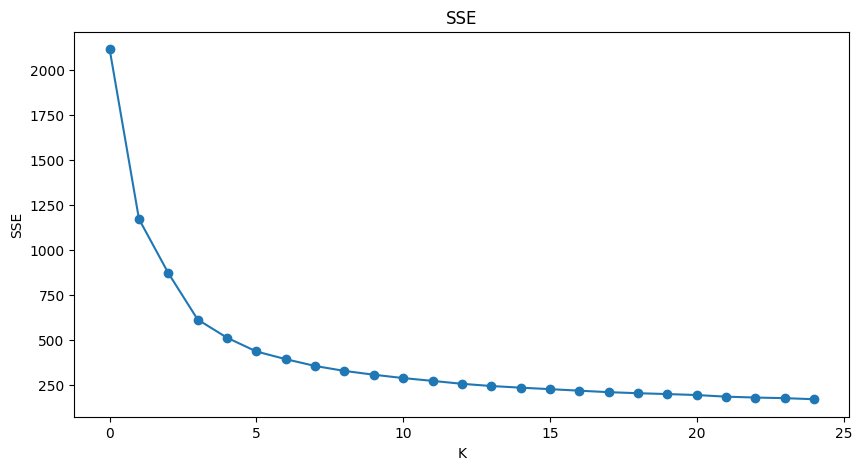

In [65]:
## Plot SSEs
values = sse.values()

# Your code here
plt.figure(figsize=(10,5))
plt.plot(values,marker = 'o')
plt.xlabel("K")
plt.ylabel("SSE")
# plt.ylim(0,1)
# plt.xticks(range(1,16))
plt.title("SSE")
plt.show()

In [66]:
## perform kmeans and add labels to data
km = kmeans_missing(atl2, n_clusters=2)
atl['cluster2'] = km[0]

km = kmeans_missing(atl2, n_clusters=4)
atl['cluster4'] = km[0]

km = kmeans_missing(atl2, n_clusters=12)
atl['cluster12'] = km[0]

## show
atl.head()

,GEOID,NAME,median_income,pct_service,pct_unemp,pct_not_labor,pct_black,pct_nonwhite,pct_public_transit,pct_commute30,pct_poverty,pct_homeowner,pct_homeowner_total,long_centroid,lat_centroid,has_missing,cluster2,cluster4,cluster12
0,13089020100,"Census Tract 201, DeKalb County, Georgia",1.775339,-1.281532,0.476188,-0.420093,-1.289705,-1.744306,-0.503315,-0.270772,-0.748720,0.661023,0.638726,-84.344272,33.798821,False,0,3,2
1,13089020200,"Census Tract 202, DeKalb County, Georgia",0.076281,-0.776823,0.005620,-0.770305,-1.221999,-1.062718,-0.776501,-0.962703,-0.410427,0.327497,0.358897,-84.340328,33.775586,False,0,2,4
2,13089020300,"Census Tract 203, DeKalb County, Georgia",1.446591,-0.630986,1.080772,-0.909649,-1.040552,-1.292303,0.652901,-0.302651,-0.687574,1.216770,1.295666,-84.329691,33.765995,False,0,3,2
3,13089020400,"Census Tract 204, DeKalb County, Georgia",1.621169,-0.833867,-0.315108,-0.777080,-1.179680,-1.465931,-0.496531,-0.002816,-1.011609,0.978921,0.812540,-84.344373,33.766102,False,0,3,2
4,13089020500,"Census Tract 205, DeKalb County, Georgia",-0.010213,-0.023582,-0.475173,-0.653191,-0.146844,-0.296485,-0.195569,-0.260417,-0.308670,0.195134,0.089077,-84.341616,33.752655,False,1,2,7


### 3. Save results

In [67]:
## save results
td = date.today().strftime("%Y%m%d")
path = '../data/' + td + '_atl_clustered.csv'
atl.to_csv(path)